In [1]:
from __future__ import print_function
import collections
import numpy as np
import pandas as pd
import pickle
import sklearn
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.regularizers import l1
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
np.random.seed(7)

# create session explicitly and keep a reference
# so we can access and evaluate tensors directly 
sess = tf.Session()
K.set_session(sess)



Using TensorFlow backend.


In [2]:
# Global config variables 
model_name = "streeteye_lstm"
#data_file = "lstm_dump_test.txt"
data_file = "dump_2017_words.txt"

checkpoint_dir = "/home/ubuntu/mount/Notebooks/checkpoints"
tensorboard_dir ="/home/ubuntu/mount/Notebooks/tensorboard"


In [3]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
data=[]
y=[]

# count words
c = collections.Counter()

with open(data_file, "r") as infile:
    for line in infile:
        l = line.rstrip('\n').split(",")
        label = l.pop(0)
        # skip empty headlines
        if len(l[0]) == 0:
            continue
        if '' in l:
            l = [w for w in l if w]
        data.append(l)
        y.append(label)
        c.update(l)
        
print("Loaded data.")


Loading data...
Loaded data.


In [4]:
# create a list of top words        
vocabulary_size = 10000 # set this to have ~20 for least popular
count = [['UNK', -1]]
count.extend(c.most_common(vocabulary_size - 1))
print(count[:10])
print(count[-10:])

[['UNK', -1], ('domain_otherdomain', 119708), ('subsource_othersubsource', 47862), ('trump', 21141), ('with', 10761), ('domain_youtube.com', 8908), ('us', 8434), ('2017', 7862), ('from', 7768), ('subsource_memeorandum', 7712)]
[('hazard', 17), ('alexei', 17), ('molly', 17), ('expel', 17), ('champ', 17), ('admiral', 17), ('conversational', 17), ('memorable', 17), ('wharton', 17), ('torn', 17)]


In [5]:
dictionary = dict()
# map words into a dict of ints
for word, _ in count:
    dictionary[word] = len(dictionary)

data_embeddings=[]
unk_count = 0

for obs in data:
    embedlist = []
    for word in obs:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        embedlist.append(index)
    data_embeddings.append(embedlist)
        
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [6]:
print(dictionary['trump'])
print(reverse_dictionary[3])

3
trump


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43fefbcc90>]], dtype=object)

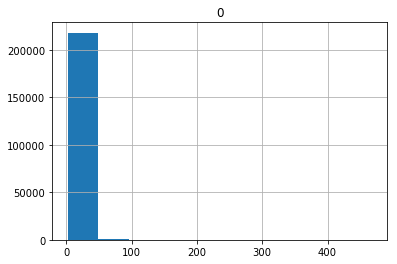

In [7]:
%matplotlib inline
ls = (map(len, data_embeddings))
pd.DataFrame(ls).hist()


In [7]:
MAX_LENGTH = 120
X = sequence.pad_sequences(data_embeddings, maxlen=MAX_LENGTH)
X[0]
X.shape

(218419, 120)

In [8]:
y=np.array(np.float32(y))

y=y.reshape((y.shape[0],1))
print(y.shape)
num_labels=1

num_obs, num_features = X.shape
print("Observations: %d\nFeatures: %d" % (num_obs, num_features))

# split into training, xval, test, 60/20/20
print("Split into training, temp")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
print("Split into xval, test")
X_xval, X_test, y_xval, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


(218419, 1)
Observations: 218419
Features: 120
Split into training, temp
Split into xval, test


In [9]:

print("Training set")
print(X_train.shape)

print("Xval set")
print(X_xval.shape)

print("Test set")
print(X_test.shape)

num_training_samples = X_train.shape[0]
num_xval_samples = X_xval.shape[0]
num_test_samples = X_test.shape[0]

print ("\nTraining observations:  %d  \nXval observations:  %d  \nTest observations:  %d\n" % (num_training_samples, num_xval_samples, num_test_samples))


Training set
(131051, 120)
Xval set
(43684, 120)
Test set
(43684, 120)

Training observations:  131051  
Xval observations:  43684  
Test observations:  43684



In [10]:
# initialize embeddings to pre-trained vals
pkl_file = open('embeddings.pkl', 'rb')
embeddings_dict, embeddings_reverse_dict, embeddings_data = pickle.load(pkl_file)

In [11]:
EMBEDDING_DIM=300

# +1 seems like an off-by-one somewhere
embedding_matrix = np.zeros((len(dictionary) + 1, EMBEDDING_DIM))

count = 0
for word, i in dictionary.items():
    #print(word)
    embed_i = embeddings_dict.get(word)
    if embed_i is not None:
        embedding_vector = embeddings_data[i]
        count +=1
        embedding_matrix[i] = embedding_vector
        
print("initialized %d embeddings" % count)

initialized 10000 embeddings


In [22]:
# function to generate model

def create_model(lstm_size=30, lstm_reg_penalty=0.0, sigmoid_dropout=(1.0/3.0), sigmoid_reg_penalty=0.0001):
    # create model
    model = Sequential()

    model.add(Embedding(len(dictionary) + 1, 
                        embedding_vector_length, 
                        weights=[embedding_matrix],
                        input_length=MAX_LENGTH,
                        trainable=True))
    
    # LSTM with lstm_size units
    model.add(LSTM(lstm_size,
                   kernel_regularizer=l1(lstm_reg_penalty)))
    model.add(Dropout(sigmoid_dropout))
    
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=l1(sigmoid_reg_penalty)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


In [23]:
def selectThreshold (logits, labels, beta=(2.0/3)):
    # return threshold, f-score that yields best F-score
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

In [30]:
# create the model
embedding_vector_length = EMBEDDING_DIM

for sig_reg_penalty in [0.00003]:
    for dropout in [0.333]:
        for lstm_units in [128]:
            for lstm_reg_penalty in [0.00000,]:
                #0.000001, 0.000003, 0.00001, 0.00003]:
                model = create_model(lstm_size=lstm_units, 
                                     lstm_reg_penalty=lstm_reg_penalty, 
                                     sigmoid_dropout=dropout, 
                                     sigmoid_reg_penalty=sig_reg_penalty)
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)
                
                model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=3, batch_size=1024)
                
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh
                
                print("Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh
                
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                

                print("Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                false_negative = confusion_matrix[0][1]
                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                    
                print ("Raw score 2 %f" % raw_score)
                
                # freeze embeddings layer and train some more
                elayer = model.layers[0]
                
                print(elayer.trainable)
                elayer.trainable = False
                print(elayer.trainable)
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                print(model.summary())
                
                model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=1, batch_size=1024)
                
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh
                
                print("Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh
                
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                

                print("Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                true_positive =  confusion_matrix[1][1]
                true_negative =  confusion_matrix[0][0]
                false_negative = confusion_matrix[0][1]
                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                    
                print ("Raw score 2 %f" % raw_score)


                


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 120, 300)          3000300   
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 3,220,077.0
Trainable params: 3,220,077.0
Non-trainable params: 0.0
_________________________________________________________________
None
LSTM units 128
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.3330
Sigmoid reg_penalty 0.00003000
Train on 131051 samples, validate on 43684 samples
Epoch 1/4
131051/131051 [==============================] - 1060s - loss: 0.1584 - acc: 0.9699 - val_loss:

KeyboardInterrupt: 

In [21]:
# freeze embeddings layer and train some more
elayer = model.layers[0]

print(elayer.trainable)
elayer.trainable = False
print(elayer.trainable)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=10, batch_size=128)


True
False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 300)          3000300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,020,605.0
Trainable params: 20,305.0
Non-trainable params: 3,000,300.0
_________________________________________________________________
None
Train on 131051 samples, validate on 43684 samples
Epoch 1/10
131051/131051 [==============================] - 177s - loss: 0.0308 - acc: 0.9921 - val_loss: 0.0568 - val_acc: 0.9834
Epoch 2/10
131051/131051 [=============================

In [22]:
y_train_prob = model.predict(X_train)
beta=(2.0/3.0) # penalize false positives more than false negatives

thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
y_train_pred = y_train_prob >= thresh
print("Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))
 

Train Accuracy 0.995, Train F1 0.904, f_score 0.922 (beta 0.667)
[[127305    500]
 [   155   3091]]


In [23]:
y_xval_prob = model.predict(X_xval)

thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
y_xval_pred = y_xval_prob >= thresh

print("Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
       sklearn.metrics.f1_score(y_xval_pred, y_xval),
       score, beta))

print(sklearn.metrics.confusion_matrix(y_xval_pred, y_xval))

       

Xval Accuracy 0.983, Xval F1 0.695, f_score 0.714 (beta 0.667)
[[42131   446]
 [  280   827]]


In [ ]:
y_test_prob = model.predict(X_test)
beta=(2.0/3.0) # penalize false positives more than false negatives

y_test_pred = y_test_prob >= thresh
print("Test Accuracy %.3f, Test F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_test_pred, y_test), 
                       sklearn.metrics.f1_score(y_test_pred, y_test),
                       score, beta))
                
print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))


In [21]:
elayer = model.layers[0]
em = sess.run(elayer.embeddings)
em.shape


(10001, 300)

In [22]:
len(dictionary)

10000

In [26]:
pickle_list = [dictionary, reverse_dictionary, em]

output = open('lstm_embeddings.pkl', 'wb')
pickle.dump(pickle_list, output)
output.close()

In [27]:
m2 = create_model(lstm_size=lstm_units, 
                                     lstm_reg_penalty=lstm_reg_penalty, 
                                     sigmoid_dropout=dropout, 
                                     sigmoid_reg_penalty=sig_reg_penalty)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 300)          3000300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,020,605.0
Trainable params: 3,020,605.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [28]:
elayer = m2.layers[0]
em = sess.run(elayer.embeddings)
em.shape

(10001, 300)

In [35]:
em[10000]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [36]:
embedding_matrix[10000]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [37]:
len(embedding_matrix)

10001

In [31]:
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh
                
                print("Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh
                
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                

                print("Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                false_negative = confusion_matrix[0][1]
                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                    
                print ("Raw score 2 %f" % raw_score)
                
                # freeze embeddings layer and train some more
                elayer = model.layers[0]
                
                print(elayer.trainable)
                elayer.trainable = False
                print(elayer.trainable)
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                print(model.summary())
                
                model.fit(X_train, y_train, validation_data=(X_xval, y_xval), epochs=5, batch_size=1024)
                
                y_train_prob = model.predict(X_train)
                
                beta=(2.0/3.0) # penalize false positives more than false negatives
                thresh, score = selectThreshold(y_train_prob, y_train, beta=beta)
                y_train_pred = y_train_prob >= thresh
                
                print("Train Accuracy %.3f, Train F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train),
                       score, beta))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThreshold(y_xval_prob, y_xval, beta=beta)
                y_xval_pred = y_xval_prob >= thresh
                
                print ("LSTM units %d" % lstm_units)
                print ("LSTM reg_penalty %.8f" % lstm_reg_penalty)
                print ("Sigmoid dropout %.4f" %  dropout)
                print ("Sigmoid reg_penalty %.8f" % sig_reg_penalty)                

                print("Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f (beta %.3f)" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval),
                       score, beta))
                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                false_positive = confusion_matrix[1][0]
                true_positive =  confusion_matrix[1][1]
                true_negative =  confusion_matrix[0][0]
                false_negative = confusion_matrix[0][1]
                raw_score = 1.0 * (true_positive - false_positive) / np.sum(confusion_matrix)
                    
                print ("Raw score 2 %f" % raw_score)



Train Accuracy 0.991, Train F1 0.833, f_score 0.846 (beta 0.667)
[[127030    723]
 [   430   2868]]
LSTM units 128
LSTM reg_penalty 0.00000000
Sigmoid dropout 0.3330
Sigmoid reg_penalty 0.00003000
Xval Accuracy 0.983, Xval F1 0.667, f_score 0.703 (beta 0.667)
[[42187   524]
 [  224   749]]
Raw score 2 0.011469
True
False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 120, 300)          3000300   
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 3,220,077.0
Trainable params: 219,777.0
Non-trainable params: 3,000,3